In [1]:
import copy
from tqdm.auto import tqdm
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt


from superprimitive_fusion.scanner import (
    capture_spherical_scans,
    virtual_mesh_scan,
    mesh_depth_image,
    generate_rgbd_noise,
    clean_mesh_and_remap_weights,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    distinct_colours,
)
from superprimitive_fusion.mesh_fusion import (
    fuse_meshes,
)
from superprimitive_fusion.mesh_fusion_utils import (
    get_mesh_components,
)

from superprimitive_fusion.evaluation import (
    evaluate_mesh_pair,
    tsdf_fuse_from_depth_data,
    mse_and_iou,
)

/Users/christopher/miniconda3/envs/msc-project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    ('table', 'table.obj'),
    ('power-drill', 'power-drill.obj'),
    ('bleach', 'bleach.obj'),
    ('pitcher', 'pitcher.obj'),
    ('mug', 'mug.obj'),
    ('extra-large-clamp', 'extra-large-clamp-leaning.obj'),
)

gt_meshes = dict()
for foldername,filename in names:
    print(f'Getting the {foldername}')
    
    gt_mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(gt_mesh)
    gt_mesh.compute_vertex_normals()

    gt_meshes[foldername] = gt_mesh

gt_mesh_list = list(gt_meshes.values())

Getting the mustard-bottle
Getting the table
Getting the power-drill
Getting the bleach
Getting the pitcher
Getting the mug
Getting the extra-large-clamp


In [3]:
gt_scene_mesh = copy.deepcopy(gt_mesh_list[0])
for i in range(1,len(gt_mesh_list)):
    gt_scene_mesh += copy.deepcopy(gt_mesh_list[i])

In [ ]:
# ok = o3d.io.write_triangle_mesh(str('evaluation/1_nonoise/gt_scene_mesh.obj'), gt_scene_mesh)
# print(ok)

[Open3D WARNING] Write OBJ can not include triangle normals.
True


In [4]:
centres = []
for gt_meshname, gt_mesh in gt_meshes.items():
    if gt_meshname == 'table':
        continue
    centres.append(gt_mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

In [ ]:
cam_offset=obj_centre
look_at = obj_centre
width: int = 360
height: int = 240
fov: float = 70.0
k: float = 3
max_normal_angle_deg = None
include_depth_images = True

def get_scans(include_depth_images:bool):
    scans = []
    scan_depth_data = []
    ccs = []
    a = 45
    c = int(360/10)
    rs = (0.45, 0.45)
    ls = (50, 80)
    for i in range(360//c):
        r = rs[0] if i%2==0 else rs[1]
        l = ls[0] if i%2==0 else ls[1]
        ccs.append(cam_offset + polar2cartesian(r=r, lat=l, long=a+i*c))
    for cc in ccs:
        object_meshes, object_weights, depth_data = virtual_mesh_scan(
            gt_mesh_list,
            cc,
            look_at,
            k=k,
            max_normal_angle_deg=max_normal_angle_deg,
            width_px=width,
            height_px=height,
            fov=fov,
            constant_uncertainty    =1e-4,#2e-4,
            linear_uncertainty      =1e-3,#2e-3,      # rate of uncertainty increase with depth
            quadrt_uncertainty      =3e-3,#1e-4,      # quadratic uncertainty coefficient
            constant_perlin_sigma   =1e-4,#2e-4,      # constant perlin noise term
            linear_perlin_sigma     =1e-3,#2e-3,      # linear depth term
            quadrt_perlin_sigma     =3e-3,#1e-4,      # quadratic depth term
            perlin_octaves          =6,
            seg_scale_std           =2e-3,#1e-4,      # std of per-segment scale noise
            rot_std                 =2e-3,#1e-4,      # std of global rotation noise
            trn_std                 =2e-3,#1e-3,      # std of global translation noise
            grazing_lambda          =5.0,#1.0       # sigma multiplier at grazing angles; 0 disables
            seed                    =None,
            include_depth_image     =True,
        )
        for mesh in object_meshes:
            mesh.compute_vertex_normals()
        scan_depth_data.append(depth_data)
        scans.append([(m,w) for m,w in zip(object_meshes, object_weights)])
    if not include_depth_images:
        return scans
    return scans, scan_depth_data

# scans, scan_depth_data = get_scans(include_depth_images)

# scan_meshes = [m for scan in scans for m,w in scan]

In [ ]:
coloured_meshes = []
dcols = distinct_colours(len(scan_meshes))
for i,mesh in enumerate(scan_meshes):
    if len(np.asarray(mesh.vertices)) == 0:
        continue
    cmesh = copy.deepcopy(mesh)
    cmesh.paint_uniform_color(dcols[i])
    coloured_meshes.append(cmesh)
o3d.visualization.draw_geometries(coloured_meshes)

(<Figure size 1500x400 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

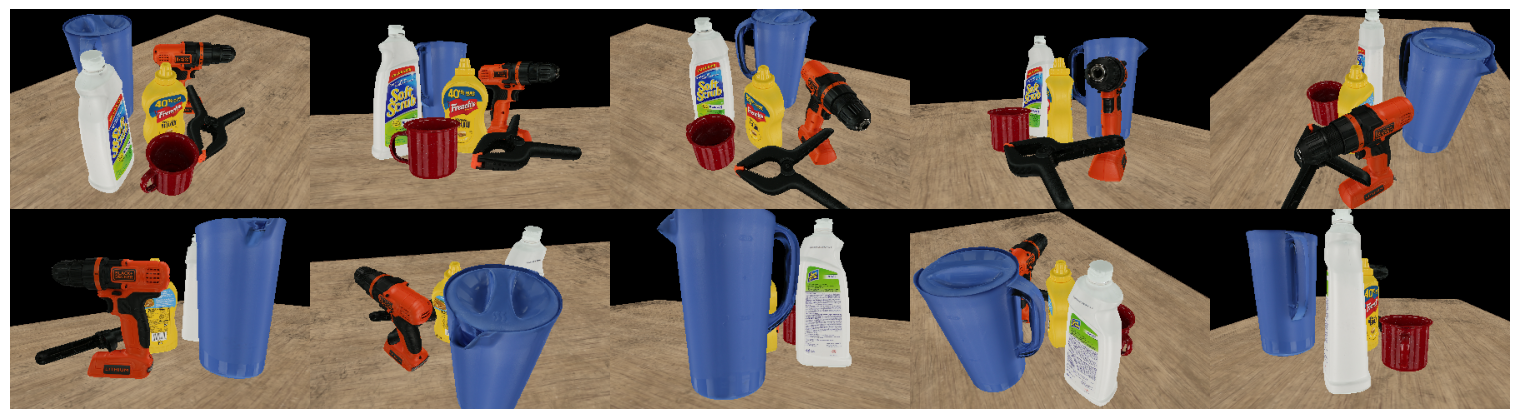

In [9]:
scans, depth_data = previous_scan
from superprimitive_fusion.utils import plot_images
rgbs = [np.flip(d['rgb'].copy(), axis=[0,1]) for d in depth_data]
depths = [np.flip(d['depth'], axis=[0,1]) for d in depth_data]
for i,rgb in enumerate(rgbs):
    rgb[~np.isfinite(depths[i])] = np.array([0,0,0])
plot_images(rgbs, max_cols=int(len(rgbs)/2))

In [6]:
def scan_and_fuse_scene(
        method:str,
        voxel_length:float|None=None,
        trunc_voxels:int|None=None,
        smooth:bool|None=None,
        nrm:bool|None=None,
        unc:bool|None=None,
        smooth_iters:float=3,
        shift_iters:int=1,
        sigma_theta:float=0.2,
        normal_diff_thresh:int=30,
        bpa_radii:list=[0,1,5,10,15,25,35,50,65,75,85,90,95,99],
        previous_scan:tuple|None=None,
        name:str='Reconstruction',
        r_alpha:float=2.0,
        h_alpha:float=6.0,
    ):
    import time

    method = method.lower()
    spf = method == 'spf'
    tsdf = method == 'tsdf'
    assert (spf and not tsdf) or (tsdf and not spf)
    if tsdf:
        assert voxel_length is not None and isinstance(voxel_length, float)
        assert smooth is not None and isinstance(smooth, bool)
        assert trunc_voxels is not None and isinstance(trunc_voxels, int)
    if spf:
        assert nrm is not None and isinstance(nrm, bool)
        assert unc is not None and isinstance(unc, bool)

    if previous_scan is None:
        print('Getting scans')
        scans, scan_depth_data = get_scans(include_depth_images=True)
    else:
        assert isinstance(previous_scan, tuple) and len(previous_scan) == 2
        scans, scan_depth_data = previous_scan
    
    print(f'Fusing using {method}')
    fusion_t0 = time.perf_counter()
        
    if tsdf:
        fused_mesh = tsdf_fuse_from_depth_data(scan_depth_data, voxel_length=voxel_length, trunc_voxels=trunc_voxels)
        if smooth:
            fused_mesh = fused_mesh.filter_smooth_simple(
                number_of_iterations=smooth_iters
            )
            fused_mesh.compute_vertex_normals()
    else:
        fused_scan = scans[0]
        N = len(scans[0])
        assert len(set([len(scan) for scan in scans])) == 1

        for t, scan in enumerate(tqdm(scans[1:], desc="Scan", unit="scan"), start=1):
            fused_scan_meshes = []
            fused_scan_weights = []
            for obj_id in tqdm(range(N), desc="Object", unit="obj", position=1, leave=False):
                mesh1, weights1 = fused_scan[obj_id]
                mesh2, weights2 = scan[obj_id]

                if len(np.asarray(mesh1.vertices)) == 0:
                    tqdm.write(f"Scan {t-1} obj {obj_id} is empty")
                    fused_obj_mesh, fused_obj_weights = mesh2, weights2
                elif len(np.asarray(mesh2.vertices)) == 0:
                    tqdm.write(f"Scan {t} obj {obj_id} is empty")
                    fused_obj_mesh, fused_obj_weights = mesh1, weights1
                else:
                    fused_obj_mesh, fused_obj_weights = fuse_meshes(
                        mesh1=mesh1, weights1=weights1 if unc else None,
                        mesh2=mesh2, weights2=weights2 if unc else None,
                        h_alpha=h_alpha, r_alpha=r_alpha,
                        nrm_shift_iters=shift_iters, nrm_smth_iters=1,
                        sigma_theta=sigma_theta,
                        normal_diff_thresh=normal_diff_thresh,
                        ball_radius_percentiles=bpa_radii,
                        bilateral_weight_update=False,
                        shift_all=False,
                    )
                fused_scan_meshes.append(fused_obj_mesh)
                fused_scan_weights.append(fused_obj_weights)
                
            fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

        fused_meshes = [obj[0] for obj in fused_scan]
        fused_mesh = copy.deepcopy(fused_meshes[0])
        for i in range(1,len(fused_meshes)):
            fused_mesh += fused_meshes[i]
    
    fusion_time_s = time.perf_counter() - fusion_t0
    triangle_count = len(fused_mesh.triangles)
    
    o3d.visualization.draw_geometries([fused_mesh], window_name=name)
    
    return {'fusion_time_s':fusion_time_s, 'triangle_count':triangle_count}

# scan_and_fuse_scene(
#     method='spf',
#     voxel_length=None,
#     trunc_voxels=None,
#     smooth=None,
#     nrm=True,
#     unc=False,
#     smooth_iters=3,
#     shift_iters=1,
#     sigma_theta=0.2,
#     normal_diff_thresh=30,
#     bpa_radii=[0,1,5,10,15,25,35,50,65,75,85,90,95,99],
# )

In [83]:
from pathlib import Path
import json

clean_res = {'fusion_time_s': 0, 'triangle_count': 2950}
iterations_per_experiment = 5
experiments = [
    {'method':'spf', 'voxel_length':None, 'trunc_voxels':None, 'smooth':None, 'nrm':True, 'unc':True, 'name':'spf unc nrm'},
    {'method':'spf', 'voxel_length':None, 'trunc_voxels':None, 'smooth':None, 'nrm':False, 'unc':True, 'name':'spf unc'},
    {'method':'spf', 'voxel_length':None, 'trunc_voxels':None, 'smooth':None, 'nrm':True, 'unc':False, 'name':'spf van nrm'},
    {'method':'spf', 'voxel_length':None, 'trunc_voxels':None, 'smooth':None, 'nrm':False, 'unc':False, 'name':'spf van'},
    {'method':'tsdf', 'voxel_length':1/295, 'trunc_voxels':4, 'smooth':False, 'nrm':True, 'unc':True, 'name':'tsdf lo'},
    {'method':'tsdf', 'voxel_length':1/295, 'trunc_voxels':4, 'smooth':True, 'nrm':True, 'unc':True, 'name':'tsdf lo smth'},
    {'method':'tsdf', 'voxel_length':1/1000, 'trunc_voxels':12, 'smooth':False, 'nrm':True, 'unc':True, 'name':'tsdf hi'},
    {'method':'tsdf', 'voxel_length':1/1000, 'trunc_voxels':12, 'smooth':True, 'nrm':True, 'unc':True, 'name':'tsdf hi smth'},
]

In [7]:
previous_scan = get_scans(include_depth_images=True)
# res = scan_and_fuse_scene(
#     previous_scan=previous_scan,
#     **experiments[0],
# )

/Users/christopher/Documents/Coding/Imperial/MSc Project/MSc-Project/src/superprimitive_fusion/scanner.py:666: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [8]:
scan_meshes = [m for scan in previous_scan[0] for m,w in scan]
coloured_meshes = []
dcols = distinct_colours(len(scan_meshes))
for i,mesh in enumerate(scan_meshes):
    if len(np.asarray(mesh.vertices)) == 0:
        continue
    cmesh = copy.deepcopy(mesh)
    cmesh.paint_uniform_color(dcols[i])
    coloured_meshes.append(cmesh)
o3d.visualization.draw_geometries(coloured_meshes)

In [ ]:
overall_results = {}
for experiment in [experiments[2], experiments[4]]:
    res = scan_and_fuse_scene(
        previous_scan=previous_scan,
        **experiment
    )
    overall_results[experiment['name']] = res


# Path("2_scene_time_and_tris.json").write_text(
#     json.dumps(overall_results, indent=2, sort_keys=True), encoding="utf-8"
# )

# loaded = json.loads(Path("metrics.json").read_text(encoding="utf-8"))

Fusing using spf


Scan:  44%|████▍     | 4/9 [01:09<01:12, 14.48s/scan] 

Scan 5 obj 5 is empty


Scan:  56%|█████▌    | 5/9 [01:26<00:59, 14.98s/scan] 

Scan 6 obj 5 is empty


Scan:  67%|██████▋   | 6/9 [01:37<00:46, 15.57s/scan] 

Scan 7 obj 2 is empty


Scan: 100%|██████████| 9/9 [02:27<00:00, 16.43s/scan]


Fusing using tsdf


186

In [11]:
from superprimitive_fusion.evaluation import tsdf_fuse
from superprimitive_fusion.utils import plot_images

def precompute_per_segment_depth_images(scene_depth_data):
    per_seg_depth_images = []

    segmt3d = np.array([d['segmt'] for d in scene_depth_data])
    depth3d = np.array([d['depth'] for d in scene_depth_data])

    seg_ids = np.unique(segmt3d)
    for seg_id in seg_ids:
        depth3d_masked = depth3d.copy()
        mask = (segmt3d!=seg_id) | ~np.isfinite(depth3d)
        depth3d_masked[mask] = 0
        seg_depth_images = [depth3d_masked[i,...] for i in range(depth3d.shape[0])]
        per_seg_depth_images.append(seg_depth_images)
    return per_seg_depth_images

def tsdf_fuse_scene_from_depth_data(depth_data, per_seg_depth_images, voxel_length=1./1024, trunc_voxels=5):
    assert isinstance(per_seg_depth_images, list) and isinstance(per_seg_depth_images[0], list)
    fused_meshes = []

    K = depth_data[0]['K_t']

    rgb_list  = [d['rgb'] for d in depth_data]
    T_wc_list = [d['E'] for d in depth_data]

    for seg_depth_images in per_seg_depth_images:
        mesh = tsdf_fuse(
            seg_depth_images, rgb_list, K, T_wc_list,
            voxel_length=voxel_length,
            trunc_voxels=trunc_voxels,
        )
        fused_meshes.append(mesh)
    return fused_meshes

per_seg_depth_images = precompute_per_segment_depth_images(scene_depth_data=depth_data_list)

In [72]:
%%time
# tsdf_lo_meshes = tsdf_fuse_scene_from_depth_data(depth_data=depth_data_list, per_seg_depth_images=per_seg_depth_images, voxel_length=1/1000, trunc_voxels=4)
tsdf_lo_mesh = tsdf_fuse_from_depth_data(depth_data=scan_depth_data, voxel_length=1/295, trunc_voxels=4)
print(f'The low TSDF mesh has {len(np.asarray(tsdf_lo_mesh.triangles))} triangles')

The low TSDF mesh has 386190 triangles
CPU times: user 1.04 s, sys: 1.02 s, total: 2.05 s
Wall time: 271 ms


In [73]:
o3d.visualization.draw_geometries([tsdf_lo_mesh])

In [35]:
%%time
tsdf_lo_mesh_smth = tsdf_lo_mesh.filter_smooth_simple(number_of_iterations=1)
tsdf_lo_mesh_smth.compute_vertex_normals()

CPU times: user 105 ms, sys: 9.77 ms, total: 115 ms
Wall time: 115 ms


TriangleMesh with 228194 points and 437597 triangles.

In [36]:
o3d.visualization.draw_geometries([tsdf_lo_mesh_smth])

In [51]:
%%time
# tsdf_hi_meshes = tsdf_fuse_scene_from_depth_data(depth_data=depth_data_list, per_seg_depth_images=per_seg_depth_images, voxel_length=1/1000, trunc_voxels=4)
tsdf_hi_mesh = tsdf_fuse_from_depth_data(depth_data=scan_depth_data, voxel_length=1/1000, trunc_voxels=12)
print(f'The high TSDF mesh has {len(np.asarray(tsdf_hi_mesh.triangles))} triangles')

The high TSDF mesh has 6974396 triangles
CPU times: user 12.9 s, sys: 8.67 s, total: 21.5 s
Wall time: 6.19 s


In [52]:
o3d.visualization.draw_geometries([tsdf_hi_mesh])

In [17]:
%%time
tsdf_hi_mesh_smth = tsdf_hi_mesh.filter_smooth_simple(number_of_iterations=3)
tsdf_hi_mesh_smth.compute_vertex_normals()

CPU times: user 737 ms, sys: 3.76 ms, total: 741 ms
Wall time: 738 ms


TriangleMesh with 2407684 points and 4768872 triangles.

In [19]:
o3d.visualization.draw_geometries([tsdf_hi_mesh_smth])

In [ ]:
fused_scan = scans[0]
N = len(scans[0])
assert len(set([len(scan) for scan in scans])) == 1

for t, scan in enumerate(tqdm(scans[1:], desc="Scan", unit="scan"), start=1):
    fused_scan_meshes = []
    fused_scan_weights = []
    for obj_id in tqdm(range(N), desc="Object", unit="obj", position=1, leave=False):
        mesh1, weights1 = fused_scan[obj_id]
        mesh2, weights2 = scan[obj_id]

        if len(np.asarray(mesh1.vertices)) == 0:
            tqdm.write(f"Scan {t-1} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh2, weights2
        elif len(np.asarray(mesh2.vertices)) == 0:
            tqdm.write(f"Scan {t} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh1, weights1
        else:
            fused_obj_mesh, fused_obj_weights = fuse_meshes(
                mesh1=mesh1, weights1=weights1,
                mesh2=mesh2, weights2=weights2,
                # h_alpha             = 3,
                # r_alpha             = 3,
                # nrm_shift_iters     = 2,
                # nrm_smth_iters      = 1,
                # sigma_theta         = 0.1,
                # normal_diff_thresh  = 20.0,
                # tau_max = None,
                # shift_all = False,
                # ball_radius_percentiles = [1,5,15,30,50,70,85,95,99],
                # bilateral_weight_update = False,
                h_alpha=5.0, r_alpha=2.0,
                nrm_shift_iters=1, nrm_smth_iters=1,
                sigma_theta=0.2,
                normal_diff_thresh=30,
                ball_radius_percentiles=[0,1,5,10,15,25,35,50,65,75,85,90,95,99],
                bilateral_weight_update=False,
                shift_all=False,
            )
        fused_scan_meshes.append(fused_obj_mesh)
        fused_scan_weights.append(fused_obj_weights)
        
    fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

spf_unc_meshes = [obj[0] for obj in fused_scan]
spf_unc_mesh = copy.deepcopy(spf_unc_meshes[0])
for i in range(1,len(spf_unc_meshes)):
    spf_unc_mesh += spf_unc_meshes[i]
print(f'The SPF unc mesh has {len(np.asarray(spf_unc_mesh.triangles))} triangles')

Scan:  44%|████▍     | 4/9 [01:12<01:15, 15.15s/scan] 

Scan 5 obj 5 is empty


Scan:  56%|█████▌    | 5/9 [01:30<01:01, 15.48s/scan] 

Scan 6 obj 5 is empty


Scan:  67%|██████▋   | 6/9 [01:41<00:49, 16.35s/scan] 

Scan 7 obj 2 is empty


Scan: 100%|██████████| 9/9 [02:31<00:00, 16.86s/scan]

The SPF unc mesh has 409339 triangles


In [57]:
o3d.visualization.draw_geometries([spf_unc_mesh])

In [7]:
fused_scan = scans[0]
N = len(scans[0])
assert len(set([len(scan) for scan in scans])) == 1

for t, scan in enumerate(tqdm(scans[1:], desc="Scan", unit="scan"), start=1):
    fused_scan_meshes = []
    fused_scan_weights = []
    for obj_id in tqdm(range(N), desc="Object", unit="obj", position=1, leave=False):
        mesh1, weights1 = fused_scan[obj_id]
        mesh2, weights2 = scan[obj_id]

        if len(np.asarray(mesh1.vertices)) == 0:
            tqdm.write(f"Scan {t-1} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh2, weights2
        elif len(np.asarray(mesh2.vertices)) == 0:
            tqdm.write(f"Scan {t} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh1, weights1
        else:
            fused_obj_mesh, _ = fuse_meshes(
                mesh1=mesh1, weights1=None,
                mesh2=mesh2, weights2=None,
                # h_alpha             = 3,
                # r_alpha             = 3,
                # nrm_shift_iters     = 2,
                # nrm_smth_iters      = 1,
                # sigma_theta         = 0.1,
                # normal_diff_thresh  = 20.0,
                # tau_max = None,
                # shift_all = False,
                # ball_radius_percentiles = [1,5,15,30,50,70,85,95,99],
                # bilateral_weight_update = False,
                h_alpha=5.0, r_alpha=2.0,
                nrm_shift_iters=1, nrm_smth_iters=1,
                sigma_theta=0.15,
                normal_diff_thresh=20,
                ball_radius_percentiles=[1,5,10,15,25,35,50,90],
                bilateral_weight_update=False,
                shift_all=False,
            )
        fused_scan_meshes.append(fused_obj_mesh)
        fused_scan_weights.append(fused_obj_weights)
        
    fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

spf_van_meshes = [obj[0] for obj in fused_scan]
spf_van_mesh = spf_van_meshes[0]
for i in range(1,len(spf_van_meshes)):
    spf_van_mesh += spf_van_meshes[i]
print(f'The SPF van mesh has {len(np.asarray(spf_van_mesh.triangles))} triangles')

Scan:   0%|          | 0/9 [00:00<?, ?scan/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 5 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 6 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 7 obj 2 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

The SPF van mesh has 431616 triangles


In [8]:
o3d.visualization.draw_geometries([spf_van_mesh])

In [14]:
spf_unc_mesh = o3d.io.read_triangle_mesh('evaluation/1_nonoise/scene/1_scene_spf_unc.ply')
spf_van_mesh = o3d.io.read_triangle_mesh('evaluation/1_nonoise/scene/1_scene_spf_van.ply')

In [ ]:
# rt = 'evaluation/1_nonoise/scene/1_scene_'
# ext = '.ply'
# meshes_and_names = [
#     (spf_unc_mesh, 'spf_unc'),
#     (spf_van_mesh, 'spf_van'), 
#     (tsdf_lo_mesh, 'tsdf_lo'), 
#     (tsdf_lo_mesh_smth, 'tsdf_lo_smth'),
#     # (tsdf_hi_mesh, 'tsdf_hi'), 
#     # (tsdf_hi_mesh_smth, 'tsdf_hi_smth'),
# ]
# for mesh_to_write,fname in meshes_and_names:
#     ok = o3d.io.write_triangle_mesh(rt+fname+ext, mesh_to_write)
#     if not ok:
#         raise RuntimeError(f"Failed to write mesh: {fname}")

In [ ]:
res = evaluate_mesh_pair('evaluation/1_nonoise/gt_scene_mesh.ply', spf_unc_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/evaluation.py:86: UserWarning: Deprecated Function Warning: use 'mesh_number()' instead.
  except Exception: return [i for i in range(ms.number_meshes())]


In [ ]:
res = evaluate_mesh_pair(gt_mesh, spf_van_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 4.0384852380717256e-05, 'median': 1.7132701139285084e-05, 'rms': 7.524295606832672e-05, 'p95': 0.0001395806485170233, 'p99': 0.00035224874428021444, 'hausdorff': 0.0007376469518846074, 'trimmed_hausdorff_99': 0.00035224874428021444, 'count': 150000}, 'gt_to_recon': {'mean': 4.270451252663487e-05, 'median': 1.73756302581686e-05, 'rms': 8.345590710805457e-05, 'p95': 0.00014688153927260158, 'p99': 0.00038730854653130036, 'hausdorff': 0.0009785458782574086, 'trimmed_hausdorff_99': 0.00038730854653130036, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9809066666666667, 'recall': 0.97676, 'fscore': 0.9788289416652477}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9977666666666667, 'recall': 0.99582, 'fscore': 0.9967923829078579}, 0.001: {'tau_m': 0.001, 'precision': 1.0, 'recall': 1.0, 'fscore': 1.0}, 0.002: {'tau_m': 0.002, '

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_lo_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 0.00011092313379871096, 'median': 8.34117831873607e-05, 'rms': 0.00015213555092778548, 'p95': 0.0003087966048076047, 'p99': 0.0004935521555266538, 'hausdorff': 0.0016186546227601184, 'trimmed_hausdorff_99': 0.0004935521555266538, 'count': 150000}, 'gt_to_recon': {'mean': 0.00010395317678521375, 'median': 8.059037894918297e-05, 'rms': 0.00013830723774120756, 'p95': 0.00028419230635734195, 'p99': 0.00042503903324442956, 'hausdorff': 0.0009138957998547914, 'trimmed_hausdorff_99': 0.00042503903324442956, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9116466666666667, 'recall': 0.92692, 'fscore': 0.9192198940478997}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9905266666666667, 'recall': 0.9957066666666666, 'fscore': 0.9931099120725438}, 0.001: {'tau_m': 0.001, 'precision': 0.9997466666666667, 'recall': 1.0, 'fscore': 0.999

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_lo_mesh_smth, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 7.352038227595891e-05, 'median': 5.548410136772125e-05, 'rms': 0.0001001215368255377, 'p95': 0.00020496659091981672, 'p99': 0.00032492141235117766, 'hausdorff': 0.000893037585018811, 'trimmed_hausdorff_99': 0.00032492141235117766, 'count': 150000}, 'gt_to_recon': {'mean': 7.424136198636982e-05, 'median': 5.545155079813083e-05, 'rms': 0.00010249635483444255, 'p95': 0.00020629872715625846, 'p99': 0.0003357382115314736, 'hausdorff': 0.0010869523918122827, 'trimmed_hausdorff_99': 0.0003357382115314736, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9740066666666667, 'recall': 0.97272, 'fscore': 0.973362908129544}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9990733333333334, 'recall': 0.99804, 'fscore': 0.9985563993363754}, 0.001: {'tau_m': 0.001, 'precision': 1.0, 'recall': 0.9999933333333333, 'fscore': 0.9999966666555555}

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_hi_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 0.00011092313379871096, 'median': 8.34117831873607e-05, 'rms': 0.00015213555092778548, 'p95': 0.0003087966048076047, 'p99': 0.0004935521555266538, 'hausdorff': 0.0016186546227601184, 'trimmed_hausdorff_99': 0.0004935521555266538, 'count': 150000}, 'gt_to_recon': {'mean': 0.00010395317678521375, 'median': 8.059037894918297e-05, 'rms': 0.00013830723774120756, 'p95': 0.00028419230635734195, 'p99': 0.00042503903324442956, 'hausdorff': 0.0009138957998547914, 'trimmed_hausdorff_99': 0.00042503903324442956, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9116466666666667, 'recall': 0.92692, 'fscore': 0.9192198940478997}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9905266666666667, 'recall': 0.9957066666666666, 'fscore': 0.9931099120725438}, 0.001: {'tau_m': 0.001, 'precision': 0.9997466666666667, 'recall': 1.0, 'fscore': 0.999

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_hi_mesh_smth, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 7.352038227595891e-05, 'median': 5.548410136772125e-05, 'rms': 0.0001001215368255377, 'p95': 0.00020496659091981672, 'p99': 0.00032492141235117766, 'hausdorff': 0.000893037585018811, 'trimmed_hausdorff_99': 0.00032492141235117766, 'count': 150000}, 'gt_to_recon': {'mean': 7.424136198636982e-05, 'median': 5.545155079813083e-05, 'rms': 0.00010249635483444255, 'p95': 0.00020629872715625846, 'p99': 0.0003357382115314736, 'hausdorff': 0.0010869523918122827, 'trimmed_hausdorff_99': 0.0003357382115314736, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9740066666666667, 'recall': 0.97272, 'fscore': 0.973362908129544}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9990733333333334, 'recall': 0.99804, 'fscore': 0.9985563993363754}, 0.001: {'tau_m': 0.001, 'precision': 1.0, 'recall': 0.9999933333333333, 'fscore': 0.9999966666555555}

In [ ]:
spf_unc_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [spf_unc_mesh],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    spf_unc_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [136]:
spf_van_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [spf_van_mesh],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    spf_van_eval_depth_data.append(depth_data)

In [134]:
tsdf_lo_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [tsdf_lo_mesh],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    tsdf_lo_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [135]:
tsdf_lo_smth_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [tsdf_lo_mesh_smth],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    tsdf_lo_smth_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [ ]:
tsdf_hi_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [tsdf_hi_mesh],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    tsdf_hi_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [ ]:
tsdf_hi_smth_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [tsdf_hi_mesh_smth],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    tsdf_hi_smth_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [137]:
print(mse_and_iou(depth_data_list, spf_unc_eval_depth_data)['overall'])

{'mse': 0.0012201191663887302, 'iou': 0.9932613579308203}


In [139]:
print(mse_and_iou(depth_data_list, spf_van_eval_depth_data)['overall'])

{'mse': 0.0036101242065795284, 'iou': 0.9793138654316079}


In [140]:
print(mse_and_iou(depth_data_list, tsdf_lo_eval_depth_data)['overall'])

{'mse': 0.003329867925109111, 'iou': 0.9781751617270619}


In [ ]:
print(mse_and_iou(depth_data_list, tsdf_lo_smth_eval_depth_data)['overall'])

{'mse': 0.003778855060117283, 'iou': 0.975867342140633}


In [ ]:
print(mse_and_iou(depth_data_list, tsdf_hi_eval_depth_data)['overall'])

{'mse': 0.003329867925109111, 'iou': 0.9781751617270619}


In [ ]:
print(mse_and_iou(depth_data_list, tsdf_hi_smth_eval_depth_data)['overall'])

{'mse': 0.003778855060117283, 'iou': 0.975867342140633}
